In [1]:
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
# from matplotlib import font_manager as fm, rcParams
import seaborn as sns
import dexplot as dxp #https://www.dexplo.org/dexplot/

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

allBounty = pd.read_csv("gitcoin_dataset_5.csv")
activity_coll = pd.read_csv("activities_collection_3.csv")
bounty_changed = pd.read_csv("changedBounty2.csv")

In [2]:
#Cleansing data------------------------------------------------------------------------------------------------

# activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)
#allBounty.drop('is_paid',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True) #This is interseting
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True) #This is interseting: may be use web3_create - cancel_on
allBounty['funding_organisation'].fillna("NA", inplace = True) #This is interseting:384 distinct org
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)#This is interseting
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)#This is interseting
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)#This is interseting
allBounty['keywords'].fillna("NA", inplace = True) #This is interseting
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True) #This is interseting
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True) #github_issue_state is interesting
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

#merge two dataframe together--------------------------------------------------------------------------------------
outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

# deal with outliers
columns_to_delete_outliers = ['duration_create_to_expire', 'duration_create_to_done', 'duration_create_to_submitted',
                             'github_comments', 'description_length', 'value_in_eth', 'value_in_usdt']

for x in columns_to_delete_outliers:
    Q1 = outer_merged[x].quantile(0.25)
    Q2 = outer_merged[x].quantile(0.50)
    Q3 = outer_merged[x].quantile(0.75)
    IQR = Q3 - Q1
    outer_merged[x] = np.where((outer_merged[x] > (Q3 + 1.5*IQR)) | (outer_merged[x]< (Q1-1.5*IQR)), Q2, outer_merged[x])

# Delete outliers and negative values for 'duration_create_to_new_bounty'
Q1 = outer_merged['duration_create_to_new_bounty'].quantile(0.25)
Q2 = outer_merged['duration_create_to_new_bounty'].quantile(0.50)
Q3 = outer_merged['duration_create_to_new_bounty'].quantile(0.75)
IQR = Q3 - Q1
outer_merged['duration_create_to_new_bounty'] = np.where((outer_merged['duration_create_to_new_bounty'] > (Q3 + 1.5*IQR)) | (outer_merged['duration_create_to_new_bounty']< 0), Q2, outer_merged['duration_create_to_new_bounty'])  

# Delete negative value for 'duration_create_to_worker_applied'
Q1_2 = outer_merged['duration_create_to_worker_applied'].quantile(0.25)
Q2_2 = outer_merged['duration_create_to_worker_applied'].quantile(0.50)
Q3_2 = outer_merged['duration_create_to_worker_applied'].quantile(0.75)
IQR_2 = Q3_2 - Q1_2
outer_merged['duration_create_to_worker_applied'] = np.where((outer_merged['duration_create_to_worker_applied'] < 0), Q2_2, outer_merged['duration_create_to_worker_applied'])

<Figure size 1080x1080 with 0 Axes>

Text(0, 0.5, 'Bounty types')

Text(0.5, 0, 'Number of issues')

Text(166.0, -0.25, '161')

Text(428.0, 0.75, '423')

Text(185.0, 1.7499999999999998, '180')

Text(182.0, 2.75, '177')

Text(138.0, 3.75, '133')

Text(1269.0, 4.75, '1264')

Text(32.0, 5.75, '27')

Text(42.0, 6.75, '37')

Text(18.0, 7.75, '13')

Text(12.0, -0.09, '7')

Text(15.0, 0.91, '10')

Text(727.0, 1.91, '722')

Text(12.0, 2.9099999999999997, '7')

Text(9.0, 3.9099999999999997, '4')

Text(31.0, 4.91, '26')

Text(6.0, 5.91, '1')

Text(6.0, 6.91, '1')

Text(6.0, 7.91, '1')

Text(120.0, 0.06999999999999999, '115')

Text(163.0, 1.07, '158')

Text(89.0, 2.07, '84')

Text(115.0, 3.07, '110')

Text(74.0, 4.07, '69')

Text(308.0, 5.07, '303')

Text(19.0, 6.07, '14')

Text(10.0, 7.07, '5')

Text(6.0, 8.07, '1')

Text(52.0, 0.22999999999999998, '47')

Text(93.0, 1.2299999999999998, '88')

Text(34.0, 2.23, '29')

Text(44.0, 3.23, '39')

Text(23.0, 4.23, '18')

Text(263.0, 5.23, '258')

Text(9.0, 6.23, '4')

Text(32.0, 7.23, '27')

Text(10.0, 8.23, '5')

Text(21.0, 0.39, '16')

Text(nan, 1.39, 'nan')

Text(nan, 2.3899999999999997, 'nan')

Text(nan, 3.3899999999999997, 'nan')

Text(nan, 4.390000000000001, 'nan')

Text(nan, 5.390000000000001, 'nan')

Text(nan, 6.390000000000001, 'nan')

Text(nan, 7.390000000000001, 'nan')

Text(nan, 8.39, 'nan')

Text(221.0, -0.26, '(3.51%)')

Text(483.0, 0.74, '(9.23%)')

Text(240.0, 1.7399999999999998, '(3.93%)')

Text(237.0, 2.74, '(3.86%)')

Text(193.0, 3.74, '(2.90%)')

Text(1324.0, 4.739999999999999, '(27.57%)')

Text(87.0, 5.739999999999999, '(0.59%)')

Text(97.0, 6.739999999999999, '(0.81%)')

Text(73.0, 7.739999999999999, '(0.28%)')

Text(67.0, -0.09999999999999998, '(0.15%)')

Text(70.0, 0.9, '(0.22%)')

Text(782.0, 1.9, '(15.75%)')

Text(67.0, 2.9, '(0.15%)')

Text(64.0, 3.9, '(0.09%)')

Text(86.0, 4.8999999999999995, '(0.57%)')

Text(61.0, 5.8999999999999995, '(0.02%)')

Text(61.0, 6.8999999999999995, '(0.02%)')

Text(61.0, 7.8999999999999995, '(0.02%)')

Text(175.0, 0.06000000000000001, '(2.51%)')

Text(218.0, 1.06, '(3.45%)')

Text(144.0, 2.06, '(1.83%)')

Text(170.0, 3.06, '(2.40%)')

Text(129.0, 4.06, '(1.51%)')

Text(363.0, 5.06, '(6.61%)')

Text(74.0, 6.06, '(0.31%)')

Text(65.0, 7.06, '(0.11%)')

Text(61.0, 8.06, '(0.02%)')

Text(107.0, 0.22, '(1.03%)')

Text(148.0, 1.2199999999999998, '(1.92%)')

Text(89.0, 2.22, '(0.63%)')

Text(99.0, 3.22, '(0.85%)')

Text(78.0, 4.22, '(0.39%)')

Text(318.0, 5.22, '(5.63%)')

Text(64.0, 6.22, '(0.09%)')

Text(87.0, 7.22, '(0.59%)')

Text(65.0, 8.22, '(0.11%)')

Text(76.0, 0.38, '(0.35%)')

Text(nan, 1.38, '(nan%)')

Text(nan, 2.38, '(nan%)')

Text(nan, 3.38, '(nan%)')

Text(nan, 4.38, '(nan%)')

Text(nan, 5.38, '(nan%)')

Text(nan, 6.38, '(nan%)')

Text(nan, 7.38, '(nan%)')

Text(nan, 8.38, '(nan%)')

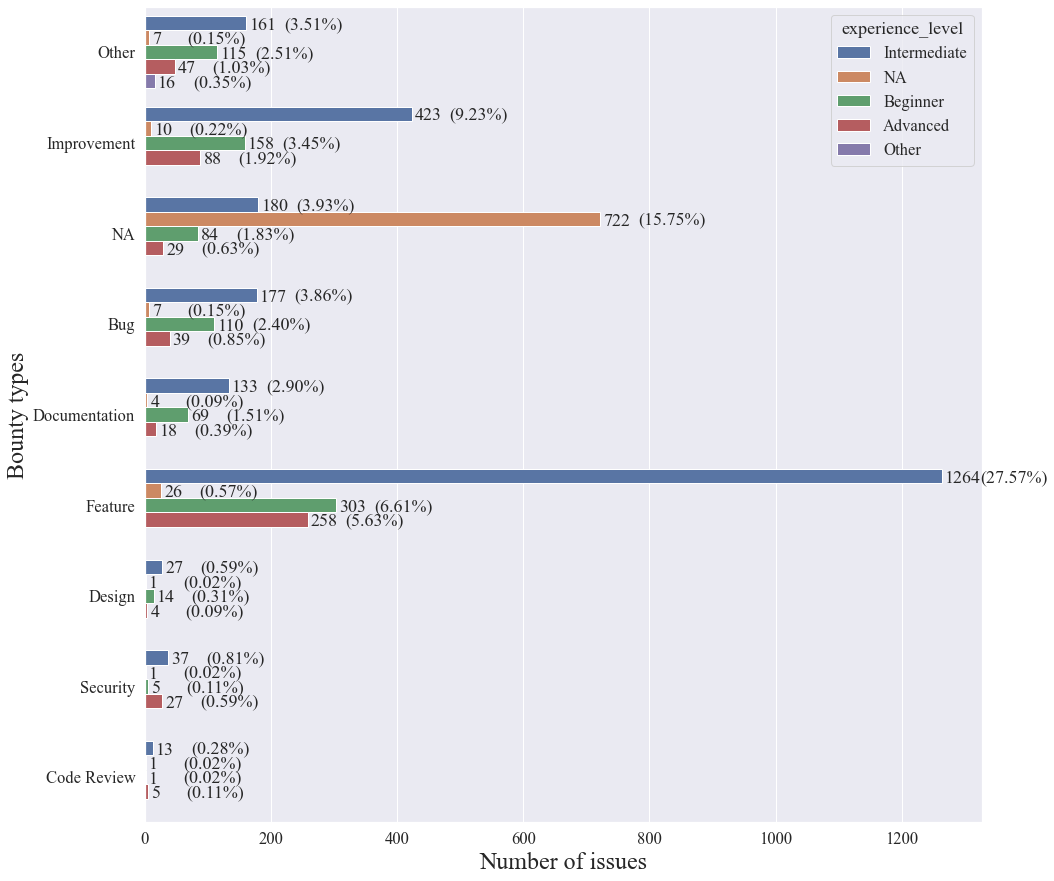

In [4]:
# The number of issues in each experience level and each bounty type

plt.figure(figsize=(15,15))

ax = sns.countplot(y='bounty_type',data = outer_merged, hue='experience_level')
ax.set_ylabel("Bounty types", fontname="Times New Roman", fontsize=24)
ax.set_xlabel("Number of issues", fontname="Times New Roman", fontsize=24)
sns.set(font_scale=1.5, font="Times New Roman")

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")

# Number of issues (integers)
for p in ax.patches:
    x = p.get_x() + p.get_width() + 5
    y = p.get_y() + 0.15
    ax.annotate('{:.0f}'.format(p.get_width()), (x,y))

# Number of issues (percentage)
for i in ax.patches:
    percentage = '({:.2f}%)'.format(100 * i.get_width()/4584)
    a = i.get_x() + i.get_width() + 60
    b = i.get_y() + 0.14
    ax.annotate(percentage, (a,b))

# Not affect the position of numbers
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .16)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/bounty_type.png', dpi = 300)
plt.show()

<Figure size 1080x1080 with 0 Axes>

Text(0, 0.5, 'Bounty types')

Text(0.5, 0, 'Number of issues')

Text(56, -0.17500000000000002, '51')

Text(78, 0.825, '73')

Text(197, 1.8250000000000002, '192')

Text(45, 2.825, '40')

Text(43, 3.825, '38')

Text(447, 4.824999999999999, '442')

Text(18, 5.824999999999999, '13')

Text(17, 6.824999999999999, '12')

Text(6, 7.824999999999999, '1')

Text(226, 0.09166666666666667, '221')

Text(578, 1.0916666666666668, '573')

Text(723, 2.091666666666667, '718')

Text(265, 3.091666666666667, '260')

Text(166, 4.091666666666667, '161')

Text(1307, 5.091666666666666, '1302')

Text(28, 6.091666666666666, '23')

Text(41, 7.091666666666666, '36')

Text(18, 8.091666666666667, '13')

Text(79, 0.3583333333333334, '74')

Text(38, 1.3583333333333334, '33')

Text(110, 2.3583333333333334, '105')

Text(38, 3.3583333333333334, '33')

Text(30, 4.3583333333333325, '25')

Text(112, 5.3583333333333325, '107')

Text(15, 6.3583333333333325, '10')

Text(27, 7.3583333333333325, '22')

Text(11, 8.358333333333334, '6')

Text(116.9, -0.18500000000000003, '(1.11%)')

Text(138.9, 0.815, '(1.59%)')

Text(257.9, 1.8150000000000002, '(4.19%)')

Text(105.9, 2.815, '(0.87%)')

Text(103.9, 3.815, '(0.83%)')

Text(507.9, 4.8149999999999995, '(9.64%)')

Text(78.9, 5.8149999999999995, '(0.28%)')

Text(77.9, 6.8149999999999995, '(0.26%)')

Text(66.9, 7.8149999999999995, '(0.02%)')

Text(286.9, 0.08166666666666667, '(4.82%)')

Text(638.9, 1.0816666666666668, '(12.50%)')

Text(783.9, 2.0816666666666666, '(15.66%)')

Text(325.9, 3.0816666666666666, '(5.67%)')

Text(226.9, 4.081666666666667, '(3.51%)')

Text(1367.9, 5.081666666666666, '(28.40%)')

Text(88.9, 6.081666666666666, '(0.50%)')

Text(101.9, 7.081666666666666, '(0.79%)')

Text(78.9, 8.081666666666667, '(0.28%)')

Text(139.9, 0.3483333333333334, '(1.61%)')

Text(98.9, 1.3483333333333334, '(0.72%)')

Text(170.9, 2.348333333333333, '(2.29%)')

Text(98.9, 3.348333333333333, '(0.72%)')

Text(90.9, 4.348333333333333, '(0.55%)')

Text(172.9, 5.348333333333333, '(2.33%)')

Text(75.9, 6.348333333333333, '(0.22%)')

Text(87.9, 7.348333333333333, '(0.48%)')

Text(71.9, 8.348333333333334, '(0.13%)')

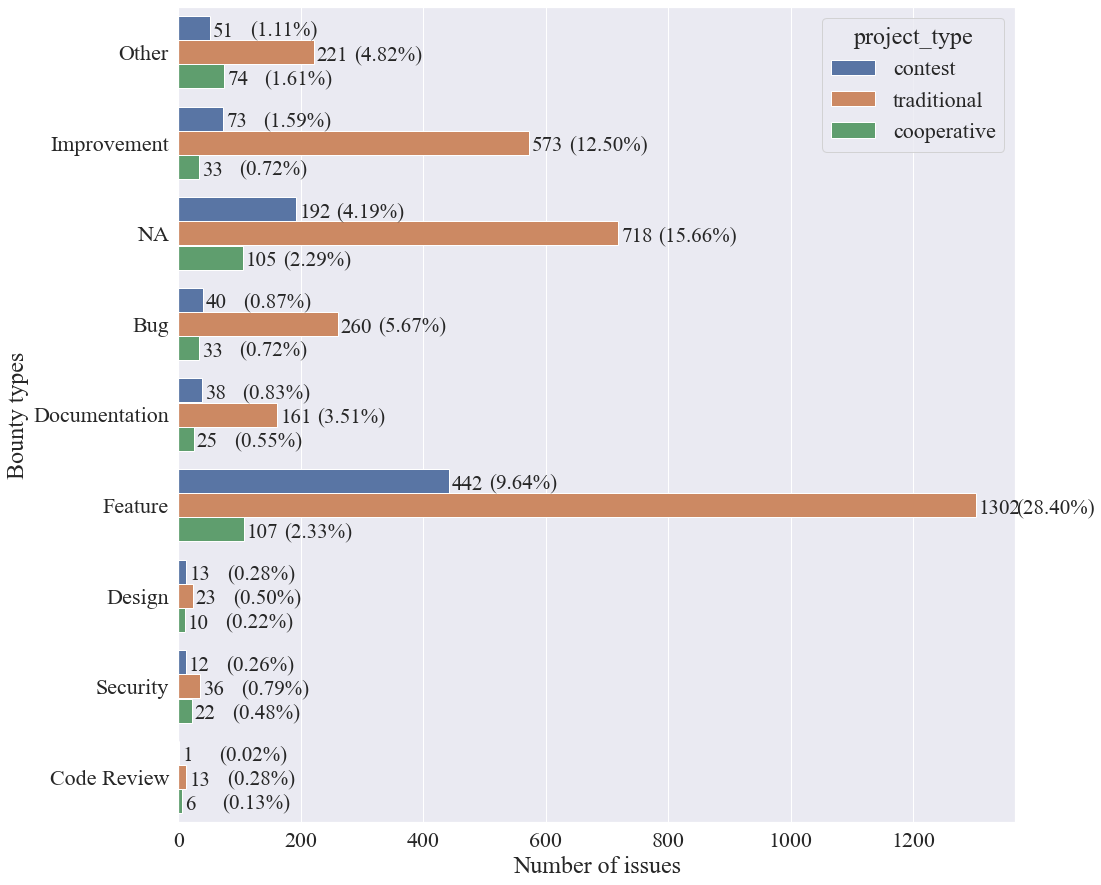

In [6]:
# The relationship between bounty types and project types

plt.figure(figsize=(15,15))

ax = sns.countplot(y='bounty_type',data = outer_merged, hue='project_type')
ax.set_ylabel("Bounty types", fontname="Times New Roman", fontsize=24)
ax.set_xlabel("Number of issues", fontname="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")

# Number of issues (integers)
for p in ax.patches:
    x = p.get_x() + p.get_width() + 5
    y = p.get_y() + 0.225
    ax.annotate('{:.0f}'.format(p.get_width()), (x,y))
    
# Number of issues (percentage)
for i in ax.patches:
    percentage = '({:.2f}%)'.format(100 * i.get_width()/4584)
    a = i.get_x() + i.get_width() + 65.9
    b = i.get_y() + 0.215
    ax.annotate(percentage, (a,b))  

# Not affect the position of numbers
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .4)

change_width(ax, .265)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/c2_byType_pjType.png', dpi = 300)
plt.show()

<AxesSubplot:title={'center':'duration_create_to_worker_applied'}, xlabel='experience_level'>

Text(0, 0.5, 'Experience levels')

Text(0.5, 0, 'Duration from issue creation until a contributor applying')

Text(0.5, 1.0, ' ')

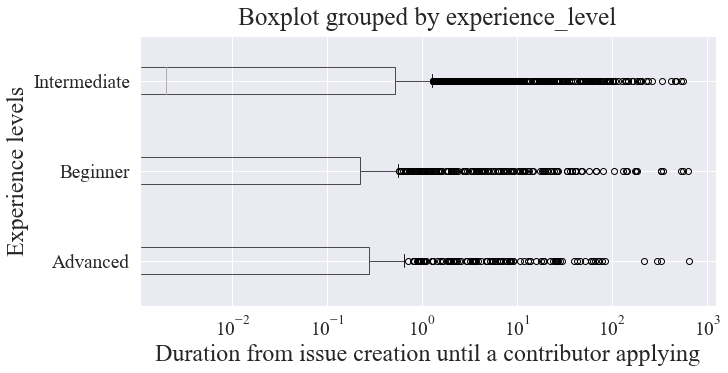

In [9]:
# The relationship between experience levels and duration from issue creation until a contributor applying

sns.set(font_scale=1.75, font="Times New Roman")

outer_merged[outer_merged['experience_level'].isin(['Beginner','Intermediate','Advanced'])].boxplot(column=['duration_create_to_worker_applied'], vert = 0, figsize=(10,5), by='experience_level')
plt.ylabel("Experience levels", size=24)
plt.xlabel("Duration from issue creation until a contributor applying", size=24)
plt.title(" ", size=18)
plt.xscale("log")

<AxesSubplot:title={'center':'duration_create_to_done'}, xlabel='experience_level'>

Text(0, 0.5, 'Experience levels')

Text(0.5, 0, 'Duration from issue creation to work done')

Text(0.5, 1.0, '')

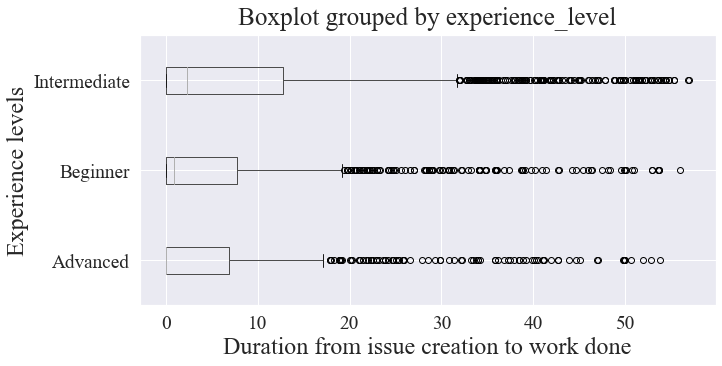

In [18]:
# The relationship between experience levels and duration from issue creation until work is done

sns.set(font_scale=1.75, font="Times New Roman")

outer_merged[outer_merged['experience_level'].isin(['Beginner','Intermediate','Advanced'])].boxplot(column=['duration_create_to_done'], vert = 0, figsize=(10,5), by='experience_level')
plt.ylabel("Experience levels", size=24)
plt.xlabel("Duration from issue creation to work done", size=24)
plt.title("", size=18)